<a href="https://colab.research.google.com/github/techpvk/EVR1/blob/main/S6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Architecture
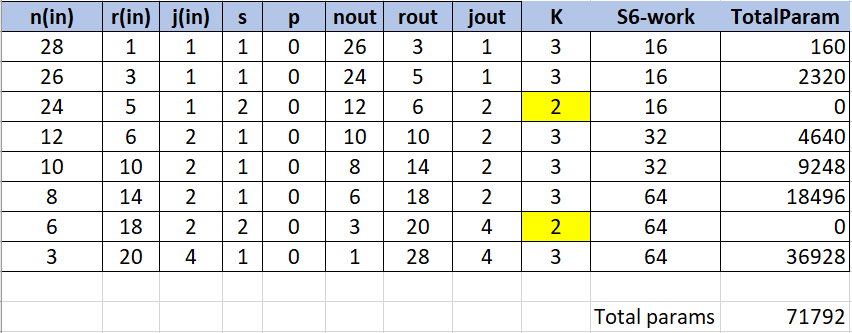

In [31]:
#Approch1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=0)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.do1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.do2 = nn.Dropout(0.2)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pool1(self.conv2_bn(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.do1(x)
        x = self.pool2(self.conv3_bn(F.relu(self.conv5(F.relu(self.conv4(F.relu(self.conv3(x))))))))
        x = self.do2(x)
        x = F.relu(self.conv6(x))
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x)

In [32]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 16, 24, 24]           2,320
       BatchNorm2d-3           [-1, 16, 24, 24]              32
         MaxPool2d-4           [-1, 16, 12, 12]               0
           Dropout-5           [-1, 16, 12, 12]               0
            Conv2d-6           [-1, 32, 10, 10]           4,640
            Conv2d-7             [-1, 32, 8, 8]           9,248
            Conv2d-8             [-1, 64, 6, 6]          18,496
       BatchNorm2d-9             [-1, 64, 6, 6]             128
        MaxPool2d-10             [-1, 64, 3, 3]               0
          Dropout-11             [-1, 64, 3, 3]               0
           Conv2d-12             [-1, 64, 1, 1]          36,928
    

<ipython-input-31-fe55dd36df11>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [33]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [34]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [35]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-31-fe55dd36df11>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.04505439102649689 batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]



Test set: Average loss: 0.0554, Accuracy: 9836/10000 (98%)



loss=0.06382658332586288 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.08it/s]



Test set: Average loss: 0.0348, Accuracy: 9894/10000 (99%)



loss=0.032026711851358414 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]



Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99%)



loss=0.03446733206510544 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0239, Accuracy: 9931/10000 (99%)



loss=0.03972868248820305 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99%)



loss=0.010217003524303436 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.42it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99%)



loss=0.007230114191770554 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99%)



loss=0.009601644240319729 batch_id=468: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0179, Accuracy: 9937/10000 (99%)



loss=0.007020637858659029 batch_id=468: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]



Test set: Average loss: 0.0157, Accuracy: 9950/10000 (100%)

